## NDBC-Explore 
## Run the cells in sequence to select dataset and variables to plot for the selected station

In [128]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import urllib.request, json
import helpers
from datetime import datetime, date, time
from ipywidgets import widgets  
from IPython import get_ipython
from IPython.display import display
from matplotlib import pylab
from pylab import *
from IPython.display import clear_output

In [129]:
%%javascript
function getQueryStringValue (key){  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("docID='".concat(getQueryStringValue("docID")).concat("'"));

<IPython.core.display.Javascript object>

In [130]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#construct url from variable
cinergi_url = "http://cinergi.sdsc.edu/geoportal/rest/metadata/item/" + docID

#Create dropdown Buttons and generate table
data_dropdown_options = helpers.create_dropdown_data (cinergi_url)
#Create widget with dropdown options from list created above
def f(notebooks_menu):
    return notebooks_menu
# out = interact(f, notebooks_menu=nb_menu);
out = interact(f, notebooks_menu=data_dropdown_options.keys());


interactive(children=(Dropdown(description='notebooks_menu', options=('59. http://www.ndbc.noaa.gov/view_text_…

In [132]:
chosen_url = data_dropdown_options[out.widget.result]
data = helpers.create_data_from_urls([chosen_url])

# Create Key Values for graph.
graphKeyVals = []

#Run all operations on Data
for i in range(len(data)):
    data[i].fillna('')
    data[i] = helpers.simplify_column_names(data[i])
    data[i] = helpers.createDateTime(data[i])
    graphKeyVals.append( data[i]['date_time'][0].year)
    data[i]['date_time']= data[i]['date_time'].apply(lambda x: x.replace(year= 2012))
#Create dropdown Buttons and generate table
dropdown_options = helpers.create_dropdowns(data)
dropdown_options.append('Choose Variable')

 read file: http://www.ndbc.noaa.gov/view_text_file.php?filename=venf1h2012.txt.gz&dir=data/historical/stdmet/


"2012 's data (number of variables in each column)"

,year,month,day,hour,minute,WDIR (degT),WSPD (m/s),GST (m/s),WVHT (m),DPD (sec),APD (sec),MWD (degT),PRES (hPa),ATMP (degC),WTMP (degC),DEWP (degC),VIS (mi),TIDE (ft),date_time
0,8777,8777,8777,8777,8777,8750,8777,8777,0,0,0,0,8777,8776,555,555,0,0,8777


In [133]:
chosen_url

'http://www.ndbc.noaa.gov/view_text_file.php?filename=venf1h2012.txt.gz&dir=data/historical/stdmet/'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'f', 'fft', 'power', 'interactive', 'info', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


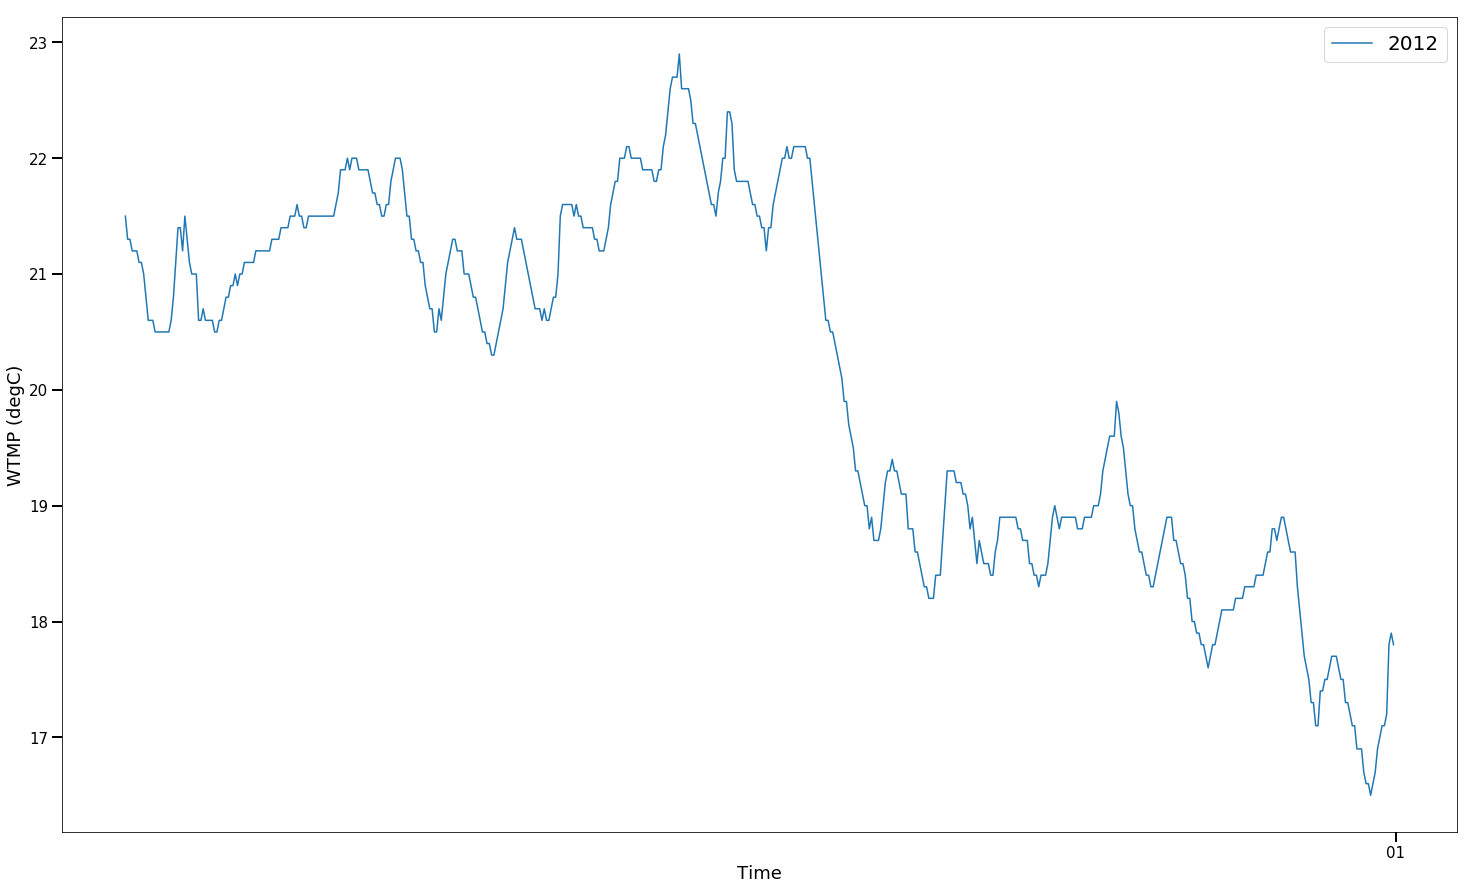

In [134]:
# Example plot of the image based on values of WTMP (Can be changed to other variables)

#Create widget with dropdown options from list created above
w = widgets.Dropdown(
    options=dropdown_options,
    description='Number:',
    disabled=False,
    value = "Choose Variable"
)

#Describe what happens when the button changes its value
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        %pylab inline
        pylab.rcParams['figure.figsize'] = (25, 15)
        helpers.plotTimeSeriesData(data,change['new'],graphKeyVals)

w.observe(on_change)
display(w)

In [ ]:
#submit usage metadata back to DDH
